# COMP 579 - Assignment 3
[Ling Fei Zhang](https://github.com/Ling01234), 260985358

Sevag Baghdassarian, ID

Brandon Ma, ID

In [49]:
# imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import gymnasium as gym
from tqdm import tqdm, trange
import random
import time
import matplotlib.colors as mcolors
from scipy.stats import sem
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.colors as mcolors


# Q-Learning Agent

In [41]:
# Actions:
# 0: left
# 1: right

# best params initialization:
ALPHA = 1/4
EPSILON = 0.25
GAMMA = 0.95
BINS = 10
EPISODES = 1000
RUNS = 10
SEED = 123
random.seed(SEED)


class Qlearning:
    def __init__(self, env, alpha, gamma, epsilon, num_episodes, num_bins, seed) -> None:
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.num_bins = num_bins
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        # self.env.seed(seed)
        self.seed = seed
        random.seed(self.seed)
        self.num_action = env.action_space.n
        self.reward = []
        self.Qvalues = np.random.uniform(low=-0.001, high=0.001,
                                         size=(num_bins, num_bins, num_bins, num_bins, self.num_action))
        self.behavior_episodes1 = []
        self.behavior_episodes2 = []
        self.behavior_episodes3 = []
        self.random_episodes1 = []
        self.random_episodes2 = []
        self.random_episodes3 = []
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], self.num_bins))
            
    # def get_behavior_episodes(self):
    #     return np.apply_along_axis(np.argmax, 4, self.Qvalues) #shape (10, 10, 10, 10)
        

    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)

    def select_action(self, state, episode):
        """
        Select action given a state

        Args:
            state (4-tuple): Current state of the agent, continuous
            episode (int): Current episode of the run

        Returns:
            int: Action chosen by the agent
        """
        random.seed(self.seed)

        # lower exploration rate as we run many episodes
        if episode > 700:
            self.epsilon *= 0.99

        # epsilon greedy
        number = np.random.random()
        if number < self.epsilon:  # uniformly choose action
            return np.random.choice(self.num_action)

        # greedy selection
        state = self.discritize_state(state)
        best_actions = np.where(
            self.Qvalues[state] == np.max(self.Qvalues[state]))[0]
        return np.random.choice(best_actions)

    def simulate_episodes(self):
        """
        Simulate a specified number of episodes
        """
        for episode in range(1, self.num_episodes+1):
            # reset env
            (state, _) = self.env.reset()
            state = list(state)

            # run episode
            episode_reward = 0
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                action = self.select_action(state, episode)
                (next_state, reward, terminal, _, _) = self.env.step(action)
                episode_reward += reward

                next_discritized_state = self.discritize_state(
                    list(next_state))

                q_max = np.max(self.Qvalues[next_discritized_state])
                self.qlearning_update(
                    terminal, reward, action, discritized_state, q_max)

                state = next_state

            self.reward.append(int(episode_reward))

    def qlearning_update(self, terminal, reward, action, state, q_max):
        """
        Qlearning update rule

        Args:
            terminal (bool): True if at terminal state, False otherwise
            reward (int): Reward of the agent at current state
            action (int): Action taken by agent
            state (4-tuple): Discrete state of the agent
            q_max (float): Max Q value of the next state
        """
        if not terminal:
            loss = reward + self.gamma * q_max - \
                self.Qvalues[state + (action,)]
        else:
            loss = reward - self.Qvalues[state + (action,)]

        self.Qvalues[state + (action,)] += self.alpha * loss

    def visualize(self, games):
        """
        Visualize the game played for a specified number of games.
        Prints out the reward for each game.

        Args:
            games (int): Number of games to be played
        """
        random.seed(self.seed)
        env = gym.make("CartPole-v1", render_mode="human")
        for game in range(games):
            (state, _) = env.reset()
            env.render()
            rewards = 0

            for _ in range(500):
                discritized_state = self.discritize_state(state)
                best_actions = np.where(self.Qvalues[discritized_state] == np.max(
                    self.Qvalues[discritized_state]))[0]
                action = np.random.choice(best_actions)
                (state, reward, terminal, _, _) = env.step(action)
                rewards += int(reward)
                time.sleep(0.05)

                if terminal:
                    time.sleep(1)
                    break
            print(f"reward for game {game}: {rewards}")
        env.close()
        
    def gather_episodes_agent(self, num_episodes):
        """
        Gather num_episodes behavior episodes for simple imitation learning

        Args:
            num_episodes (int): number of behavior episodes desired

        Returns:
            int: return of simple imitation learning using Q-Learning Agent
            as expert.
        """
        self.simulate_episodes()
        print(f"reward after simulate_episode: {self.reward[-20:]}")
        for episode in trange(1, num_episodes+1):
            # if episode % 10 == 0:
            #     print(f"gather episode {episode}")
            state, _ = self.env.reset()
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                best_actions = np.where(self.Qvalues[discritized_state] == np.max(
                    self.Qvalues[discritized_state]))[0]
                action = np.random.choice(best_actions)
                (next_state, reward, terminal, _, _) = self.env.step(action)
                discritized_next_state = self.discritize_state(next_state)
                
                if episode <= 100:
                    self.behavior_episodes1.append((discritized_state, action, reward, discritized_next_state, terminal))
                    self.behavior_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                if episode <= 250:
                    self.behavior_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                self.behavior_episodes3.append((discritized_state, action, reward, discritized_next_state, terminal))
                
                state = next_state

    
    def gather_episodes_random(self, num_episodes):
        """
        Gather num_episodes behavior episodes with a random agent

        Args:
            num_episodes (int): number of behavior episodes desired for simple imitation

        Returns:
            int: return by a random agent. 
        """
        # print(f"reward after simulate_episode: {self.reward[-20:]}")
        for episode in trange(1, num_episodes+1):
            # if episode % 10 == 0:
            #     print(f"random agent episode {episode}")
            state, _ = self.env.reset()
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                action = self.env.action_space.sample()
                (next_state, reward, terminal, _, _) = self.env.step(action)
                discritized_next_state = self.discritize_state(next_state)
                
                if episode <= 100:
                    self.random_episodes1.append((discritized_state, action, reward, discritized_next_state, terminal))
                    self.random_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                if episode <= 250:
                    self.random_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                self.random_episodes3.append((discritized_state, action, reward, discritized_next_state, terminal))
                
                state = next_state
        



# Simple Imitation

In [42]:
class SimpleImitation:
    def __init__(self, env, dataset) -> None:
        self.env = env
        self.dataset = dataset
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], 10))
            
            
    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)


    def forward(self, num_episode = 1):
        model = LogisticRegression()
        x = np.array([data[0] for data in self.dataset])
        y = np.array([data[1] for data in self.dataset])
        model.fit(x, y)
        
        rewards = []
        for _ in range(1, num_episode + 1):
            state, _ = self.env.reset()
            episode_reward = 0
            terminal = False
            while not terminal:
                state = np.array(self.discritize_state(state))
                action = model.predict(state.reshape(1, -1))[0]
                state, reward, terminal, *_ = self.env.step(action)
                episode_reward += reward
                
            rewards.append(int(episode_reward))
        return rewards
    

Here, we will run a test run on the model, and see how it performs

In [43]:
def test_model():
    env = gym.make("CartPole-v1")
    qlearning = Qlearning(env, ALPHA, GAMMA, EPSILON, EPISODES, BINS, SEED)
    qlearning.gather_episodes_agent(500)
    qlearning.gather_episodes_random(500)
    imitation_expert = SimpleImitation(env, qlearning.behavior_episodes3)
    expert_reward = imitation_expert.forward()
    imitation_random = SimpleImitation(env, qlearning.random_episodes3)
    random_reward = imitation_random.forward()
    print(f"Simple imitation with expert agent reward: {expert_reward}")
    print(f"Simple imitation with random agent reward: {random_reward}")
    env.close()
    return qlearning.behavior_episodes1, qlearning.random_episodes1, qlearning.behavior_episodes2, qlearning.random_episodes2, qlearning.behavior_episodes3, qlearning.random_episodes3
    
data_expert100, data_random100, data_expert250, data_random250, data_expert500, data_random500 = test_model()    

reward after simulate_episode: [75, 106, 99, 78, 92, 111, 93, 68, 91, 98, 104, 105, 97, 117, 114, 112, 98, 97, 106, 99]


100%|██████████| 500/500 [00:00<00:00, 1232.00it/s]


Simple imitation with expert agent reward: [105]
Simple imitation with random agent reward: [11]


We have pre-trained our Q-Learning agent with 1000 episodes, as we did in the previous assignment. We then use the trained Q-Learning agent as our expert in simple imitation learning and used logisitc regression to imitate the action observed in each state. The results above were produced using 500 behavior episodes. We can see that we can get decent results from simple imitation learning. On the other hand, we can see the returns received by the random agent. Without surprise, the returns are very low. 

# Datasets
Below, we will create the mixed datasets.

In [44]:
# Shuffled data
mixed_data_expert = random.sample(data_expert500, 500)
mixed_data_random = random.sample(data_random500, 500)
mixed_data = mixed_data_expert + mixed_data_random

# Mixed data
mixed_data100 = mixed_data_expert[:int(len(mixed_data)/10)]
mixed_data250 = mixed_data_expert[:int(len(mixed_data)/4)]
mixed_data500 = mixed_data_expert[:int(len(mixed_data)/2)]

# Fitted Q-Learning

In [45]:
class FittedQLearning:
    def __init__(self, env, buffer, gamma=0.99, num_episodes=500, batch_size=64, buffer_size=5000, approximator="linear"):
        self.env = env
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.buffer = buffer
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.approximator = approximator
        self.Qvalues = np.random.uniform(low=-0.001, high=0.001,
                                         size=(10, 10, 10, 10, self.action_space))
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], 10))
        self.reward = []
        
    
    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)
    
    def update(self):
        """
        Fitted Q Learning update step. This is done in batch.
        For linear function approximation, we are using tabular RL.
        We can directly minimize the mean square error to 0 by replacing
        the qvalue of a (state, action) pair by the target qvalue. 
        """
        if len(self.buffer) > self.batch_size:
            batch_index = np.random.choice(len(self.buffer), size=self.batch_size)
            batch = [self.buffer[i] for i in batch_index]
            states, actions, rewards, next_states, dones = zip(*batch)
            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            next_states = np.array(next_states)
            dones = np.array(dones)
            
            max_qvalues = np.zeros(self.batch_size)
            for index, next_state, in enumerate(next_states):
                if not dones[index]:
                    next_state = self.discritize_state(list(next_state))
                    max_qvalues[index] = np.max(self.Qvalues[next_state]) 
            
            targets = rewards + self.gamma * max_qvalues # 1 x batch_size
            
            for i, target in enumerate(targets):
                state = states[i]
                state = tuple(state)
                action = actions[i]
                self.Qvalues[state + (action,)] = target
                
                
    def select_action(self, state):
        """
        Select an action based on current state

        Args:
            state (4-tuple): current state of agent, discritized

        Returns:
            int: action taken based on greedy selection (i.e. no exploration)
        """
        best_actions = np.where(
            self.Qvalues[state] == np.max(self.Qvalues[state]))[0]
        return np.random.choice(best_actions)

    def remember(self, state, action, reward, next_state, done):
        """
        add a sample to the replay buffer

        Args:
            state (4-tuple): current state of the agent
            action (int): action taken by agent
            reward (int): reward received
            next_state (4-tuple): next state of agent
            done (bool): whether the next step terminates the game
        """
        self.buffer.append((state, action, reward, next_state, done))

    def train(self):
        """
        Train the agent on a specified number of episodes
        """
        for _ in trange(1, self.num_episodes+1):
            self.update()

    def test(self, num_episode=1):
        """
        Test the trained fitted q learning agent on a simple game
        and record the return of the agent.

        Returns:
            int: return of the agent
        """
        rewards = []
        for episode in range(1, num_episode + 1):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            while not done:
                state = self.discritize_state(list(state))
                action = self.select_action(state)
                state, reward, done, *_ = self.env.step(action)
                episode_reward += reward

            rewards.append(int(episode_reward))
        return rewards
    

In [46]:
def test_model_fitted():
    env = gym.make("CartPole-v1")
    model = FittedQLearning(env, data_expert500)
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with expert data reward: {reward}")
    model = FittedQLearning(env, data_random500)
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with random data reward: {reward}")
    model = FittedQLearning(env, mixed_data500)
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with mixed data reward: {reward}")
    env.close()
    
test_model_fitted()

100%|██████████| 500/500 [00:00<00:00, 792.02it/s]


Fitted Q Learning with expert data reward: [99]


100%|██████████| 500/500 [00:00<00:00, 835.50it/s]


Fitted Q Learning with random data reward: [84]


100%|██████████| 500/500 [00:00<00:00, 812.70it/s]

Fitted Q Learning with mixed data reward: [105]


From the results above, we can clearly see the effect of the datasets. With the expert data, we have the best return by agent. This is to be expected, as the agent used the best data there is. Then, we observed a very low return by the agent when trained using random data. This is essentially the same as not learned anything, i.e. just taking actions randomly. Lastly, when we mixed the expert data and the random data, we observed a decent return, but not as good as the return by the first agent. This is also natural, as the agent was able to partly learn from the expert data. 

# Bar Plots

First, we define a function to plot the bar plots

In [79]:
def plot(size):
    env = gym.make("CartPole-v1")
    if size == 100:
        expert = data_expert100
        rand = data_random100
        mixed = mixed_data100
    elif size == 250:
        expert = data_expert250
        rand = data_random250
        mixed = mixed_data250
    else: # size == 500
        expert = data_expert500
        rand = data_random500
        mixed = mixed_data500
    
    imitation_expert = SimpleImitation(env, expert)
    imitation_reward_expert = imitation_expert.forward(100)
    imitation_se_expert = np.std(imitation_reward_expert)/np.sqrt(len(imitation_reward_expert))
    imitation_reward_expert = np.mean(imitation_reward_expert)
    
    imitation_random = SimpleImitation(env, rand)
    imitation_reward_random = imitation_random.forward(100)
    imitation_se_random = np.std(imitation_reward_random)/np.sqrt(len(imitation_reward_random))
    imitation_reward_random = np.mean(imitation_reward_random)
    
    imitation_mixed = SimpleImitation(env, mixed)
    imitation_reward_mixed = imitation_mixed.forward(100)
    imitation_se_mixed = np.std(imitation_reward_mixed)/np.sqrt(len(imitation_reward_mixed))
    imitation_reward_mixed = np.mean(imitation_reward_mixed)
    
    fitted_expert = FittedQLearning(env, expert)
    fitted_expert.train()
    fitted_reward_expert = fitted_expert.test(100)
    fitted_se_expert = np.std(fitted_reward_expert)/np.sqrt(len(fitted_reward_expert))
    fitted_reward_expert = np.mean(fitted_reward_expert)
    
    fitted_random = FittedQLearning(env, rand)
    fitted_random.train()
    fitted_reward_random= fitted_random.test(100)
    fitted_se_random = np.std(fitted_reward_random)/np.sqrt(len(fitted_reward_random))
    fitted_reward_random= np.mean(fitted_reward_random)
    
    fitted_mixed = FittedQLearning(env, mixed)
    fitted_mixed.train()
    fitted_reward_mixed = fitted_mixed.test(100)
    fitted_sd_mixed = np.std(fitted_reward_mixed)/np.sqrt(len(fitted_reward_mixed))
    fitted_reward_mixed = np.mean(fitted_reward_mixed)
    
    average_expert = (imitation_reward_expert + fitted_reward_expert)/2
    average_random = (imitation_reward_random + fitted_reward_random)/2
    
    model = ["Simple Imitation Expert", "Simple Imitation Random", "Simple Imitation Mixed", "FittedQLearning Expert", "FittedQLearning Random", "FittedQLearning Mixed"]
    returns = [imitation_reward_expert, imitation_reward_random, imitation_reward_mixed, fitted_reward_expert, fitted_reward_random, fitted_reward_mixed]
    errors = [imitation_se_expert, imitation_se_random, imitation_se_mixed, fitted_se_expert, fitted_se_random, fitted_sd_mixed]
    colors = [mcolors.TABLEAU_COLORS["tab:blue"],
              mcolors.TABLEAU_COLORS["tab:green"], 
              mcolors.TABLEAU_COLORS["tab:orange"],
              mcolors.TABLEAU_COLORS["tab:purple"],
              mcolors.TABLEAU_COLORS["tab:cyan"],
              mcolors.TABLEAU_COLORS["tab:brown"],
              ]
    
    plt.bar(model, returns, color=colors, yerr=errors, capsize=5)
    plt.ylabel("Average Return")
    plt.xlabel("Agent")
    plt.xticks(rotation="vertical")
    plt.title(f"Average return by Agent with {size} episodes")
    
    xlimit = plt.xlim()[1]
    handles = [plt.Rectangle((0,0), 1, 1, color=color) for color in colors]
    plt.legend(handles, model, loc="best", bbox_to_anchor = (1, 0.7))
    plt.axhline(y=average_expert, color="black", linestyle="dashed")
    plt.text(xlimit + 0.2, average_expert, f"Expert Average: {average_expert:.3}", va="center", ha="left", color="black", fontsize=10)
    plt.axhline(y=average_random, color="red", linestyle="dashed")
    plt.text(xlimit + 0.2, average_random, f"Random Average: {average_random:.3}", va="center", ha="left", color="red", fontsize=10)
    plt.show()
    
        

Now, we can call the function to actually plot our 3 plots, 1 plot for each **size** of the dataset.

100%|██████████| 500/500 [00:00<00:00, 755.72it/s]


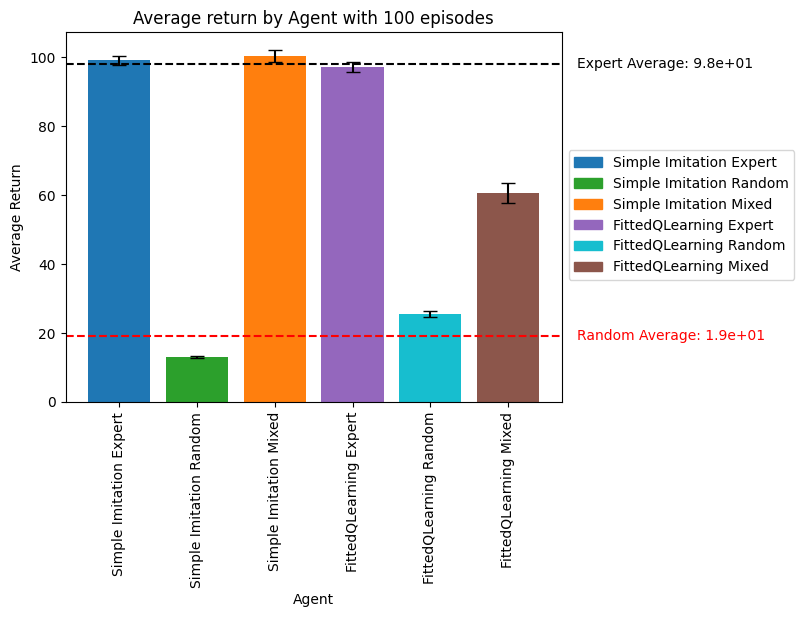

100%|██████████| 500/500 [00:00<00:00, 796.82it/s]


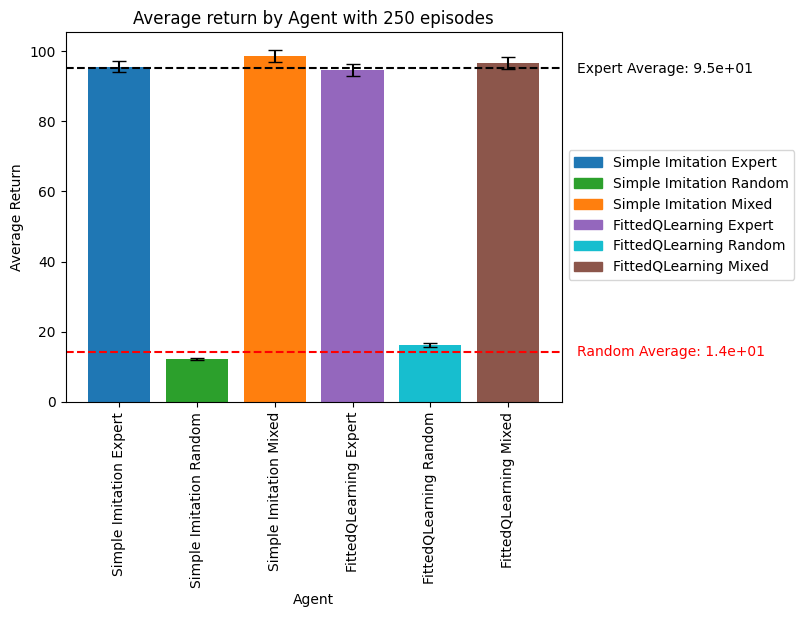

100%|██████████| 500/500 [00:00<00:00, 783.57it/s]


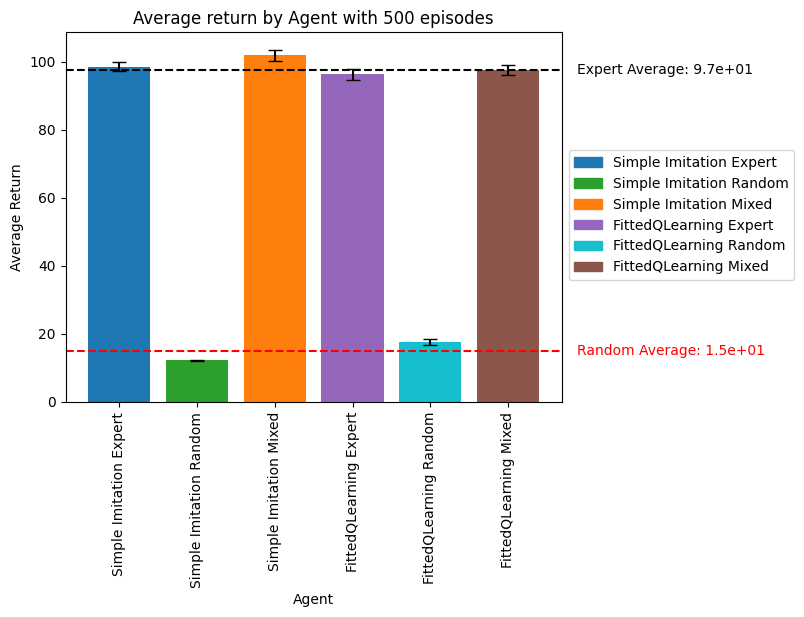

In [80]:
plot(100)
plot(250)
plot(500)